In [ ]:
# loading the data
import zipfile
import xarray as xr
import matplotlib.pyplot as plt

pre_ind_years = [f"195{i}" for i in range(10)]
post_ind_years = [f"20{i}" for i in range(15, 26)]
years = [*pre_ind_years, *post_ind_years]
# years = [1953]
# unzipping all files

for year in pre_ind_years:
  zip_path = f"./data/unzipped/percip_{year}.grib"  # your current file
  with zipfile.ZipFile(zip_path, "r") as zf:
      print("Files in archive:", zf.namelist())
      # Extract everything to a folder
      zf.extractall(f"./data/unzipped/percip_{year}/")


for year in post_ind_years:
  zip_path = f"./data/unzipped/percip_{year}.zip"  # your current file
  with zipfile.ZipFile(zip_path, "r") as zf:
      print("Files in archive:", zf.namelist())
      # Extract everything to a folder
      zf.extractall(f"./data/unzipped/percip_{year}/")

Files in archive: ['data.grib']
Files in archive: ['data.grib']
Files in archive: ['data.grib']
Files in archive: ['data.grib']
Files in archive: ['data.grib']
Files in archive: ['data.grib']
Files in archive: ['data.grib']
Files in archive: ['data.grib']
Files in archive: ['data.grib']
Files in archive: ['data.grib']
Files in archive: ['data.grib']
Files in archive: ['data.grib']
Files in archive: ['data.grib']
Files in archive: ['data.grib']
Files in archive: ['data.grib']
Files in archive: ['data.grib']
Files in archive: ['data.grib']
Files in archive: ['data.grib']
Files in archive: ['data.grib']
Files in archive: ['data.grib']
Files in archive: ['data.grib']


In [7]:
import xarray as xr

datasets_pre_ind = []
datasets_after_ind = []
for year in pre_ind_years:
  datasets_pre_ind.append(xr.open_dataset(f"./data/unzipped/percip_{year}/data.grib", engine="cfgrib"))

for year in post_ind_years:
  datasets_after_ind.append(xr.open_dataset(f"./data/unzipped/percip_{year}/data.grib", engine="cfgrib"))

Ignoring index file './data/unzipped/percip_1950/data.grib.5b7b6.idx' older than GRIB file
Ignoring index file './data/unzipped/percip_1951/data.grib.5b7b6.idx' older than GRIB file
Ignoring index file './data/unzipped/percip_1952/data.grib.5b7b6.idx' older than GRIB file
Ignoring index file './data/unzipped/percip_1953/data.grib.5b7b6.idx' older than GRIB file
Ignoring index file './data/unzipped/percip_1954/data.grib.5b7b6.idx' older than GRIB file
Ignoring index file './data/unzipped/percip_1955/data.grib.5b7b6.idx' older than GRIB file
Ignoring index file './data/unzipped/percip_1956/data.grib.5b7b6.idx' older than GRIB file
Ignoring index file './data/unzipped/percip_1957/data.grib.5b7b6.idx' older than GRIB file
Ignoring index file './data/unzipped/percip_1958/data.grib.5b7b6.idx' older than GRIB file
Ignoring index file './data/unzipped/percip_1959/data.grib.5b7b6.idx' older than GRIB file
Ignoring index file './data/unzipped/percip_2015/data.grib.5b7b6.idx' older than GRIB file

In [9]:
ds_pre = xr.combine_by_coords(datasets_pre_ind, combine_attrs="override")
ds_post = xr.combine_by_coords(datasets_after_ind, combine_attrs="override")

C:\Users\Carsten\AppData\Local\Temp\ipykernel_12492\2955944134.py:1: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'latitude' ('latitude',) The recommendation is to set join explicitly for this case.
  ds_pre = xr.combine_by_coords(datasets_pre_ind, combine_attrs="override")
C:\Users\Carsten\AppData\Local\Temp\ipykernel_12492\2955944134.py:1: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'longitude' ('longitude',) The recommendation is to set join explicitly for this case.
  ds_pre = xr.combine_by_coords(datasets

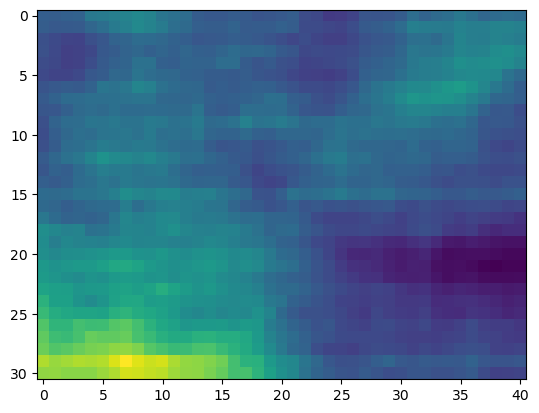

In [17]:
plt.imshow(ds_post.where(ds_post.tp > .0001).tp.mean(["time", "step"]).values)

In [22]:
# preprocessing
def compute_wet_hour_average(ds, var_name='tp', threshold=0.1*0.001):
    """
    Metric 1: Mean Wet-Hour Intensity (Agricultural Focus).
    
    Logic:
    1. Filter out all hours where rain <= 0.1 mm (trace/zero).
    2. Calculate the mean of the REMAINING hours.
    
    Returns:
    A 2D DataArray (lat/lon) of average intensity (mm/hr) when it actually rains.
    """
    print(f"Computing Mean Wet-Hour Intensity (Threshold > {threshold}mm)...")
    
    # Select only wet hours; convert dry hours to NaN
    wet_hours = ds.where(ds[var_name] > threshold)
    
    # Calculate mean along the time dimension (ignoring NaNs automatically)
    intensity = wet_hours[var_name].mean(["time", "step"])
    
    return intensity

def compute_high_threshold_pot(ds, var_name='tp', quantile=0.95):
    """
    Metric 2: Peaks Over Threshold (POT) Average (Storm/Covariance Focus).
    
    Logic:
    1. Determine the 95th percentile (or other q) of WET HOURS at each location.
       (Note: We calculate quantile on wet hours only, not all hours, to avoid zero-bias).
    2. Filter for events exceeding this high threshold.
    3. Average those extremes.
    
    Returns:
    A 2D DataArray of the average magnitude of top-tier storms.
    """
    print(f"Computing POT Average (Events > {quantile*100}th percentile of wet hours)...")
    
    # 1. Isolate wet hours first
    wet_hours = ds.where(ds[var_name] > 0.01*0.001)
    
    # 2. Calculate the dynamic threshold for each pixel
    # Note: .quantile can be memory intensive on huge datasets. 
    # For terabyte-scale data, use dask or compute percentiles on a subset/climatology.
    thresholds = wet_hours.quantile(quantile, dim=['time', "step"], keep_attrs=True)
    
    # 3. Filter for events strictly greater than the local 95th percentile
    extreme_events = wet_hours.where(wet_hours > thresholds)
    
    # 4. Average the magnitude of these extreme events
    pot_average = extreme_events.mean(["time", "step"])
    
    return pot_average[var_name]

Computing Mean Wet-Hour Intensity (Threshold > 0.0001mm)...


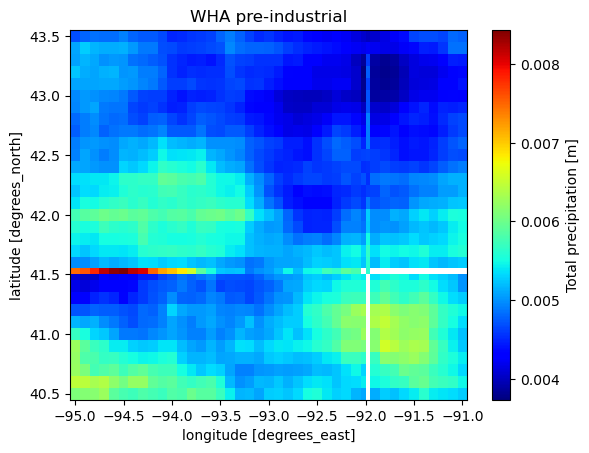

Computing POT Average (Events > 95.0th percentile of wet hours)...


c:\Users\Carsten\anaconda3\envs\geospatial-analysis\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


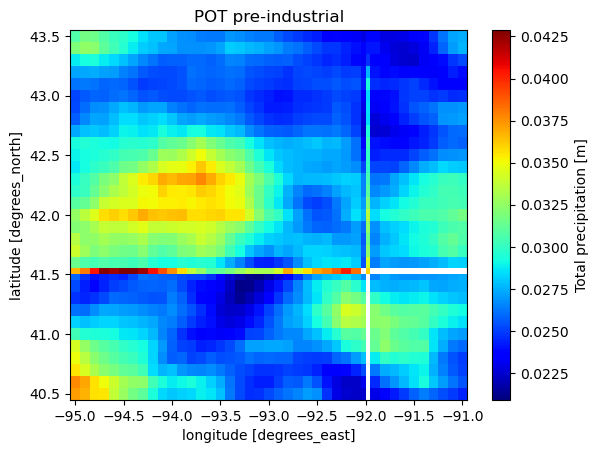

Computing Mean Wet-Hour Intensity (Threshold > 0.0001mm)...


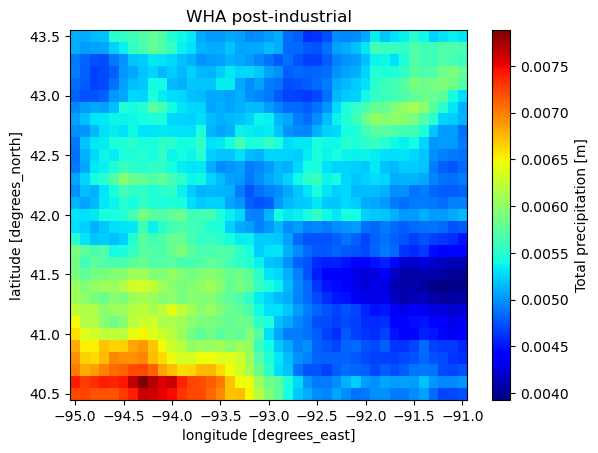

Computing POT Average (Events > 95.0th percentile of wet hours)...


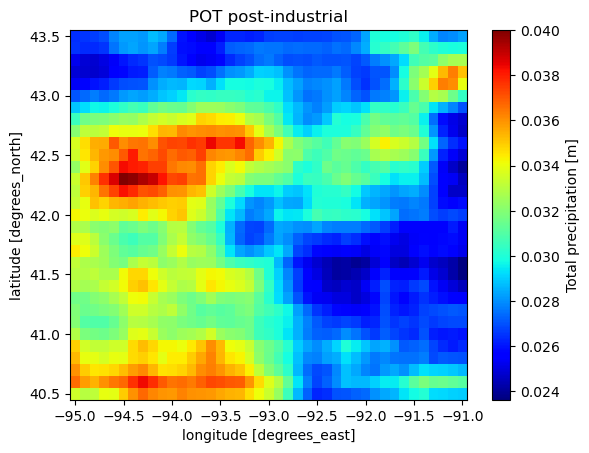

In [44]:
compute_wet_hour_average(ds_pre).plot(cmap=plt.cm.jet)
plt.title("WHA pre-industrial")
plt.show()
compute_high_threshold_pot(ds_pre).plot(cmap=plt.cm.jet)
plt.title("POT pre-industrial")
plt.show()


compute_wet_hour_average(ds_post).plot(cmap=plt.cm.jet)
plt.title("WHA post-industrial")
plt.show()
compute_high_threshold_pot(ds_post).plot(cmap=plt.cm.jet)
plt.title("POT post-industrial")
plt.show()



## Saving the data

In [26]:
ds_post

<xarray.Dataset> Size: 43MB
Dimensions:     (time: 352, step: 24, latitude: 31, longitude: 41)
Coordinates:
  * time        (time) datetime64[ns] 3kB 2015-06-30 2015-07-01 ... 2025-07-31
  * step        (step) timedelta64[ns] 192B 01:00:00 ... 1 days 00:00:00
  * latitude    (latitude) float64 248B 43.5 43.4 43.3 43.2 ... 40.7 40.6 40.5
  * longitude   (longitude) float64 328B -95.0 -94.9 -94.8 ... -91.2 -91.1 -91.0
    number      int64 8B 0
    surface     float64 8B 0.0
    valid_time  (time, step) datetime64[ns] 68kB 2015-06-30T01:00:00 ... 2025...
Data variables:
    tp          (time, step, latitude, longitude) float32 43MB nan nan ... nan
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-12-05T17:07 GRIB to CDM+CF via cfgrib-0.9.1...

In [24]:
import geopandas as gpd

# trying to save as gpkn to have an easier time with variogram analysis in gstat
def save_as_gpkg(dataset: xr.Dataset, name: str):
  df = dataset.to_dataframe().reset_index()
  gdf = gpd.GeoDataFrame(df,
                        geometry=gpd.points_from_xy(df["latitude"], df["longitude"]))
  gdf.to_file(f"./data/processed/{name}.gpkg")

save_as_gpkg(compute_high_threshold_pot(ds_post), "post_wet_hours")
save_as_gpkg(compute_wet_hour_average(ds_post), "post_pot")

Computing POT Average (Events > 95.0th percentile of wet hours)...
Computing Mean Wet-Hour Intensity (Threshold > 0.0001mm)...


c:\Users\Carsten\anaconda3\envs\geospatial-analysis\Lib\site-packages\pyogrio\geopandas.py:917: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
c:\Users\Carsten\anaconda3\envs\geospatial-analysis\Lib\site-packages\pyogrio\geopandas.py:917: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


Computing POT Average (Events > 95.0th percentile of wet hours)...


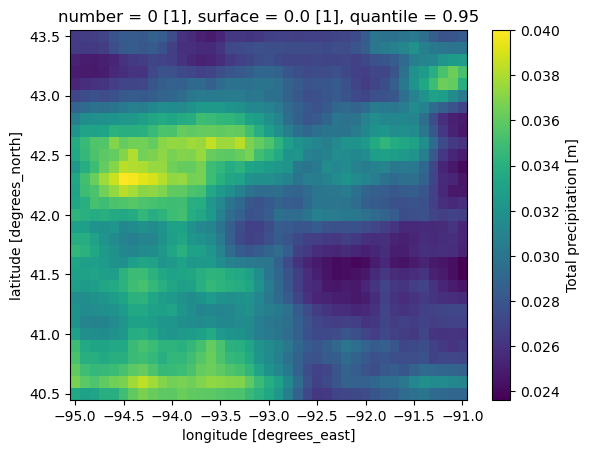

In [29]:
compute_high_threshold_pot(ds_post).plot()

In [ ]:
import numpy as np

# saving the data for analysis
np.savetxt("./data/processed/post_ind_wet_hours.csv", compute_wet_hour_average(ds_post).values, delimiter=",")
np.savetxt("./data/processed/post_pot_mean.csv", compute_high_threshold_pot(ds_post), delimiter=",")

Computing Mean Wet-Hour Intensity (Threshold > 0.0001mm)...
Computing POT Average (Events > 95.0th percentile of wet hours)...
